# Modélisation d'un VotingClassifier

### Plan
- Importation des librairies nécessaires à l'utlisation des GPU
- Sélection des variables par arbre de décisions
- Création et comparaison de modèles linéaires et non-linéaires
- Création et comparaison du voting classifier


### Utilisation d'un notebook déja préparé
- Il n'y a plus de donnée manquantes (Iterative imputer)
- Il n'y a plus de variables corrélées avec d'autres variables (Pearson>0.8)
- Features ingenering : 6 variables sup contruit à partir de variables existantes
- Les outliers et données atypiques ont été supprimées


#### Importation des librairies nécessaires à l'utlisation des GPU

In [1]:
# Vérif matériel
!nvidia-smi

Thu Oct 12 12:42:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Chargement des librairies (4 minutes)

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
# This will update the Colab environment and restart the kernel.
# Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [1]:
# This will install CondaColab.  This will restart your kernel one last time.
# Run this cell by itself and only run the next cell once you see the session crash.

import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [1]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# 15 minutes
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Importation des librairies classiques

import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import numpy as np
import time

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report,precision_recall_curve,roc_curve, auc,confusion_matrix

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Importation des librairies GPU de cuml

#from cuml.preprocessing import MinMaxScaler

from cuml.model_selection import train_test_split
from cuml.model_selection import GridSearchCV

from sklearn.ensemble import VotingClassifier

from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
import xgboost as xgb
import time

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
path="/content/drive/MyDrive/Colab Notebooks/Machine Learning/"
df=pd.read_csv(path + "df.csv")
df.drop("SK_ID_CURR",axis=1,inplace=True)
df.head(5)

,TARGET,Contrat,Genre,Voiture,FLAG_OWN_REALTY,Salaire,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,Anciennete,sum,count,max,ANCxCRED,ANC_par_CRED,Anc_Age,Salaire_PER_PERSON,Annuite_Salaire,PAYMENT_RATE
0,1.0,0.0,1.0,0.0,1.0,202500.0,406597.5,6.0,7.0,4.0,...,1.745205,481988.565,2.0,-103.0,7.095962e+05,0.000004,0.067329,202500.0,0.121978,0.060749
1,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,1.0,4.0,1.0,...,3.254795,810000.000,1.0,-606.0,4.210085e+06,0.000003,0.070862,135000.0,0.132217,0.027598
2,0.0,1.0,1.0,1.0,1.0,67500.0,135000.0,6.0,7.0,4.0,...,0.616438,0.000,0.0,0.0,8.321918e+04,0.000005,0.011814,67500.0,0.100000,0.050000
3,0.0,0.0,0.0,0.0,1.0,135000.0,312682.5,6.0,7.0,4.0,...,8.326027,0.000,0.0,0.0,2.603403e+06,0.000027,0.159905,67500.0,0.219900,0.094941
4,0.0,0.0,1.0,0.0,1.0,121500.0,513000.0,6.0,7.0,4.0,...,8.323288,0.000,0.0,0.0,4.269847e+06,0.000016,0.152418,121500.0,0.179963,0.042623


In [8]:
df.shape

(306946, 53)

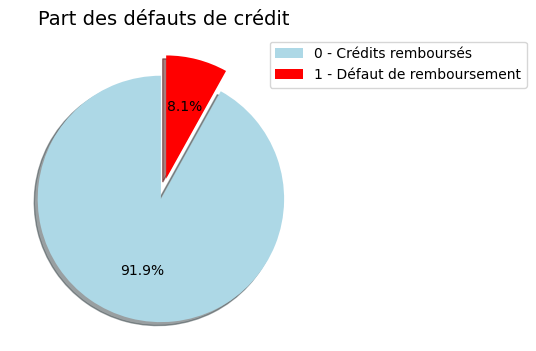

In [9]:
labels =df['TARGET'].value_counts(sort = True).index
sizes = df['TARGET'].value_counts(sort = True)

colors = ["lightblue","red"]
explode = (0.1,0.07)

plt.figure(figsize=(4,4))
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)
plt.legend(["0 - Crédits remboursés", "1 - Défaut de remboursement"], loc="lower right",bbox_to_anchor=(1.7, 0.8))

plt.title('Part des défauts de crédit',fontsize=14)
plt.show()

In [10]:
target = df[["TARGET"]]
df.drop("TARGET",axis=1,inplace=True)

In [11]:
# Fonction qui enregistre les graphs

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [12]:
# Fonction Matrice de confusion

def plot_confusion_matrix(y_true, y_pred, classes=['Class 0', 'Class 1']):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predictions')
    plt.ylabel('Currently')
    plt.title('Confusion Matrix')

    plt.show()


In [13]:
# Fonction Calcul de la courbe ROC

def courbe_roc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")

    plt.show()


In [14]:
# Fonction trace Precision/Recall

img_name = "precision_recall_vs_threshold_plot"

def precision_recall(clf,list_dim=[-5, 7, -0.1, 1.1],threshold = 1.8):

    y_scores =  cross_val_predict(clf, X_train.to_numpy(),
                                  y_train.to_numpy(), cv=3,
                                  method="decision_function")

    precisions, recalls, thresholds = precision_recall_curve(y_train.to_numpy(), y_scores)


    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

    idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
    plt.plot(thresholds[idx], precisions[idx], "bo")
    plt.plot(thresholds[idx], recalls[idx], "go")
    plt.axis(list_dim)
    plt.grid()
    plt.xlabel("Threshold")
    plt.legend(loc="center right")

    plt.show()

### Transformation Min Max

In [15]:
import cudf
import cudf

# Mise à l'echelle Min Max

df_cuml = cudf.DataFrame.from_pandas(df)

target_cuml= cudf.DataFrame.from_pandas(target)
target_cuml=target_cuml["TARGET"]

# Création d'un objet MinMaxScaler
scaler = MinMaxScaler()

# Mise à l'échelle sur vos données (fit et transform)

df_min_max_numpy = scaler.fit_transform(df_cuml.to_numpy())

In [16]:
df_min_max = cudf.DataFrame(df_min_max_numpy,columns=df.columns)

## Split en train set et test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split( df_min_max,
                                                    target_cuml,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=target)

## Sélection des variables par arbre de décision
Utilisation d'un random-forest utilisant le critère de Gini pour selectionner les 10 meilleurs variables.

In [18]:
# Création un modèle d'arbre de décision avec l'indice de Gini comme critère


tree_model = DecisionTreeClassifier(criterion='gini', random_state=42)
tree_model.fit(X_train.to_numpy(), y_train.to_numpy())
importance = tree_model.feature_importances_


In [19]:
# Evaluation du modèle

y_pred = tree_model.predict(X_test.to_numpy())

accuracy = accuracy_score(y_test.to_numpy(), y_pred)
print("\nPrécision du modèle:", accuracy)

report = classification_report(y_test.to_numpy(), y_pred)
print("\nRapport de classification:\n", report)


Précision du modèle: 0.8493704083793514

Rapport de classification:
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.92     56321
         1.0       0.14      0.16      0.15      5068

    accuracy                           0.85     61389
   macro avg       0.53      0.54      0.53     61389
weighted avg       0.86      0.85      0.85     61389



<Axes: xlabel='Importance', ylabel='Variable'>

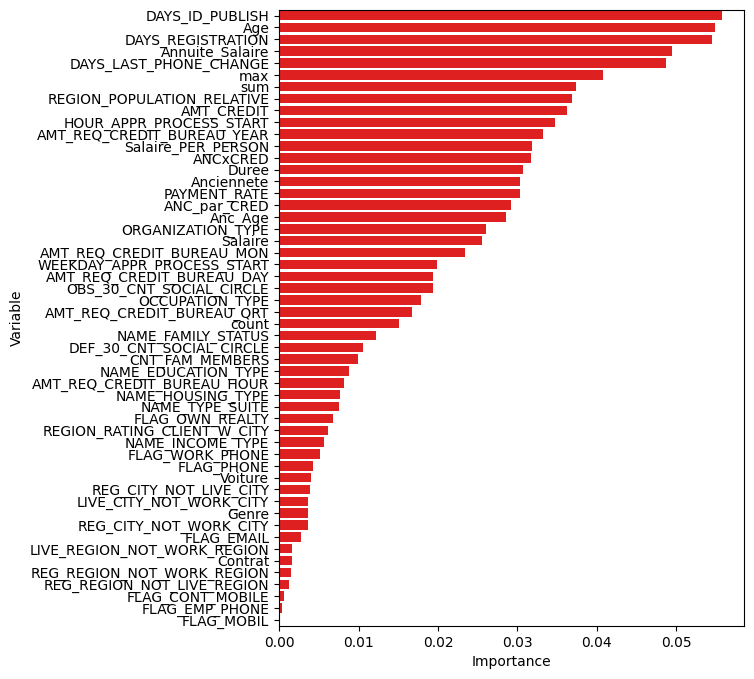

In [20]:
# Création un DataFrame et affichache de l'importance des variables

df_linear = pd.DataFrame({'Variable': df.columns, 'Importance': importance})
df_linear = df_linear.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(data=df_linear, x ="Importance" , y ="Variable", color ='r', orient='h')

In [21]:
# On ne conserve que les 20 variables les plus discriminantes au sens de l'arbre de décision

list_col = list(df_linear[df_linear['Importance']>0.025].Variable)
list_col

['DAYS_ID_PUBLISH',
 'Age',
 'DAYS_REGISTRATION',
 'Annuite_Salaire',
 'DAYS_LAST_PHONE_CHANGE',
 'max',
 'sum',
 'REGION_POPULATION_RELATIVE',
 'AMT_CREDIT',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'Salaire_PER_PERSON',
 'ANCxCRED',
 'Duree',
 'Anciennete',
 'PAYMENT_RATE',
 'ANC_par_CRED',
 'Anc_Age',
 'ORGANIZATION_TYPE',
 'Salaire']

In [22]:
X_train_selected = X_train.loc[:,list_col]
X_test_selected = X_test.loc[:,list_col]


X_train_selected.head(5)

,DAYS_ID_PUBLISH,Age,DAYS_REGISTRATION,Annuite_Salaire,DAYS_LAST_PHONE_CHANGE,max,sum,REGION_POPULATION_RELATIVE,AMT_CREDIT,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,Salaire_PER_PERSON,ANCxCRED,Duree,Anciennete,PAYMENT_RATE,ANC_par_CRED,Anc_Age,ORGANIZATION_TYPE,Salaire
39565,0.424899,0.839290,0.794707,0.070255,0.263747,1.000000,0.000000,0.491595,0.207881,0.739130,0.147231,0.113818,0.000000,0.342125,0.000000,0.254346,0.000000,0.000000,1.000000,0.216052
198929,0.349451,0.308794,0.883228,0.064563,0.581547,0.955510,0.003673,0.097483,0.072160,0.652174,0.198322,0.132090,0.017215,0.193383,0.141972,0.425257,0.037646,0.269086,0.087719,0.113392
165331,0.335556,0.385344,0.742218,0.044377,0.559879,0.847365,0.001713,0.097483,0.111216,0.565217,0.198322,0.269128,0.063478,0.204277,0.361322,0.408630,0.066127,0.619910,0.526316,0.253383
192568,0.741559,0.342390,0.878607,0.055878,0.830848,0.926078,0.018063,0.134897,0.370135,0.173913,0.274673,0.166349,0.078295,0.613248,0.145936,0.100617,0.008746,0.264445,0.543860,0.323378
290894,0.398499,0.805524,0.825105,0.042942,0.965750,0.883641,0.005207,0.260475,0.252427,0.608696,0.083797,0.194328,0.000000,0.415295,0.000000,0.199842,0.000000,0.000000,1.000000,0.380541


## Modèles Linéaires

In [43]:
# Tous les clf seront listés
classifiers = []

### 1) Régression logistique avec GPU

In [44]:
# Logistic Regression avec GPU

start_time = time.time()

log_reg_params = {'C': [0.1, 1, 10] }

log_reg = GridSearchCV( LogisticRegression(penalty='l2',
                                          class_weight="balanced" ,
                                          max_iter=350),
                       log_reg_params,
                        cv=3)

y_train = y_train.astype(int)
log_reg.fit(X_train_selected.to_numpy(), y_train.to_numpy())

end_time = time.time()
time_Reg = end_time - start_time

print(f"Temps écoulé pour Logistic Regression GridSearchCV (GPU): {time_Reg} secondes")
classifiers.append(('Logistic Regression', log_reg))

Temps écoulé pour Logistic Regression GridSearchCV (GPU): 1.485032081604004 secondes


In [26]:
y_pred = log_reg.predict(X_test_selected.to_numpy())

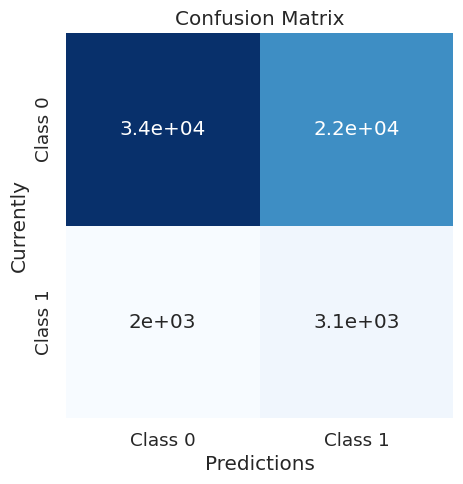

In [27]:
# Matrice de confusion

plot_confusion_matrix(y_test.to_numpy(), y_pred, classes=['Class 0', 'Class 1'])

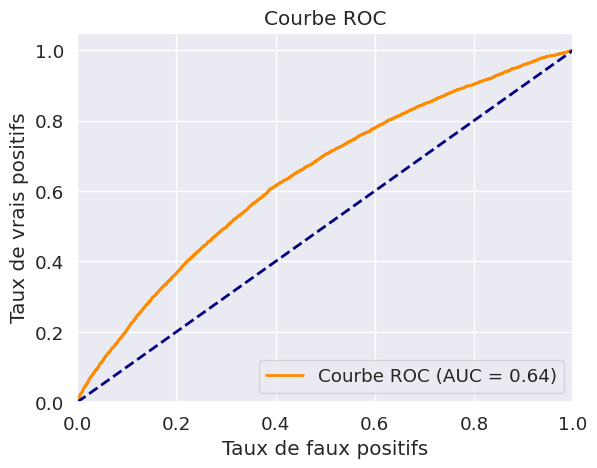

In [28]:
# Courbe ROC et AUC

y_pred_proba = log_reg.predict_proba(X_test_selected.to_numpy())

courbe_roc(y_test.to_numpy(), y_pred_proba[:,1])

[W] [13:34:27.158325] L-BFGS: max iterations reached
[W] [13:34:27.159642] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


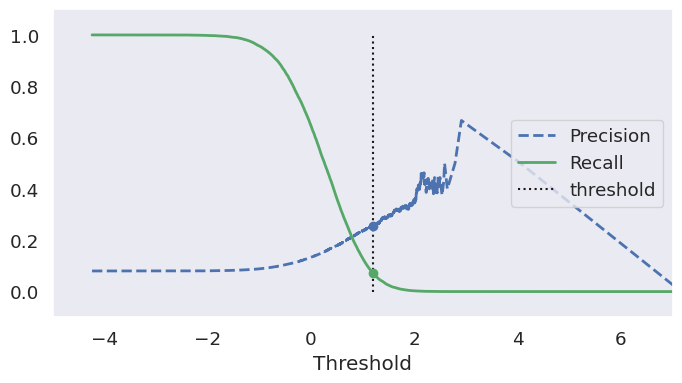

In [29]:
precision_recall(log_reg,threshold=1.2)

### 2) Support Vector Machine avec GPU

In [ ]:

# Support Vector Machine avec GPU

start_time = time.time()

svm_params = {'C': [1, 10, 100], 'kernel': ['linear', 'rbf']}

svm = GridSearchCV(SVC(probability=True, class_weight='balanced'), svm_params, cv=3)

svm.fit(X_train.to_pandas(), y_train.to_pandas())

end_time = time.time()
time_svm = end_time - start_time

print(f"Temps écoulé pour Support Vector Machine GridSearchCV (GPU): {time_svm} secondes")
classifiers.append(('Support Vector Machine', svm))

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes=['Class 0', 'Class 1'])

In [ ]:
courbe_roc(y_test, y_pred_proba)

In [ ]:
precision_recall(thresholds,threshold, precisions, recalls,svm)

## Modèle non-Linéaire avec GPU

### 1) Random Forest avec GPU

In [45]:
# Random Forest avec GPU
start_time = time.time()

rf_params = {'n_estimators': [50, 100, 200]}

rf = GridSearchCV(RandomForestClassifier(), rf_params)

rf.fit(X_train_selected.to_numpy(), y_train.to_numpy())

end_time = time.time()
time_rf = end_time - start_time

print(f"Temps écoulé pour Random Forest GridSearchCV (GPU): {time_rf}secondes")
classifiers.append(('Random Forest', rf))

Temps écoulé pour Random Forest GridSearchCV (GPU): 23.617245197296143secondes


In [31]:
rf

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 200]})

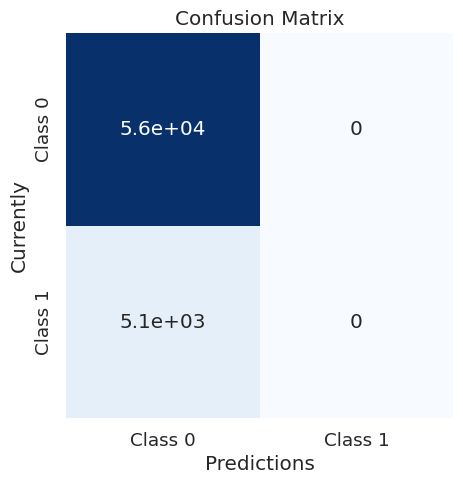

In [32]:
y_pred = rf.predict(X_test_selected.to_numpy())
plot_confusion_matrix(y_test.to_numpy(), y_pred, classes=['Class 0', 'Class 1'])

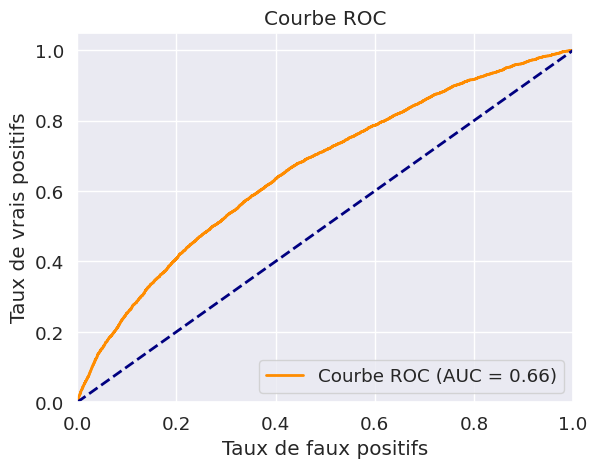

In [33]:
# Courbe ROC et AUC

y_pred_proba = rf.predict_proba(X_test_selected.to_numpy())

courbe_roc(y_test.to_numpy(), y_pred_proba[:,1])

In [ ]:
precision_recall(rf,threshold=1.2)


### 2) XGBoost classifier avec GPU

In [46]:
# XGBoost avec GPU

start_time = time.time()

xgb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}

xgb_model = GridSearchCV(xgb.XGBClassifier(tree_method='gpu_hist'), xgb_params, cv=3)

xgb_model.fit(X_train_selected.to_numpy(), y_train.to_numpy())

end_time = time.time()
time_xgb = end_time - start_time

print(f"Temps écoulé pour XGBoost GridSearchCV (GPU): {time_xgb}secondes")
classifiers.append(('XGBoost', xgb_model))

Temps écoulé pour XGBoost GridSearchCV (GPU): 13.70609426498413secondes


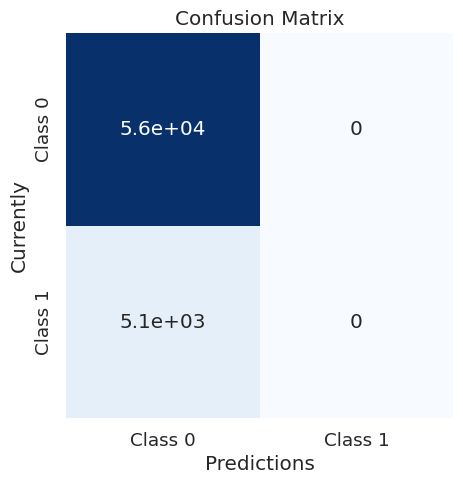

In [ ]:
y_pred = xgb_model.predict(X_test_selected)
plot_confusion_matrix(y_test.to_numpy(), y_pred, classes=['Class 0', 'Class 1'])

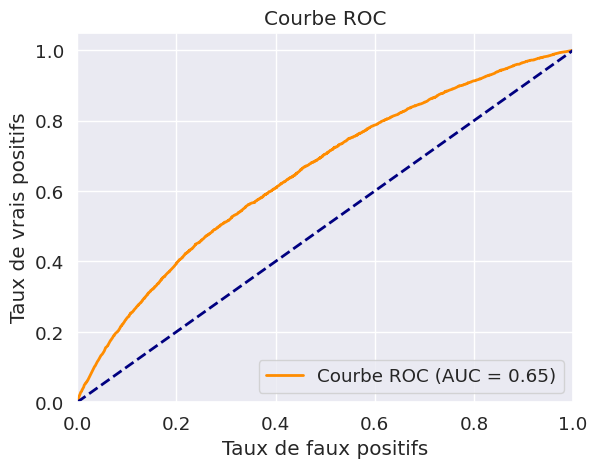

In [ ]:
# Courbe ROC et AUC

y_pred_proba = xgb_model.predict_proba(X_test_selected.to_numpy())

courbe_roc(y_test.to_numpy(), y_pred_proba[:,1])

In [ ]:
precision_recall(thresholds,threshold, precisions, recalls,xgb_model)

## VotingClassifier

In [48]:
# Create a VotingClassifier
voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')

# Train and evaluate the VotingClassifier
voting_classifier.fit(X_train_selected.to_numpy(), y_train.to_numpy())
accuracy = voting_classifier.score(X_test_selected.to_numpy(), y_test.to_numpy())

print("Voting Classifier Accuracy:", accuracy)

Voting Classifier Accuracy: 0.9174607828764111


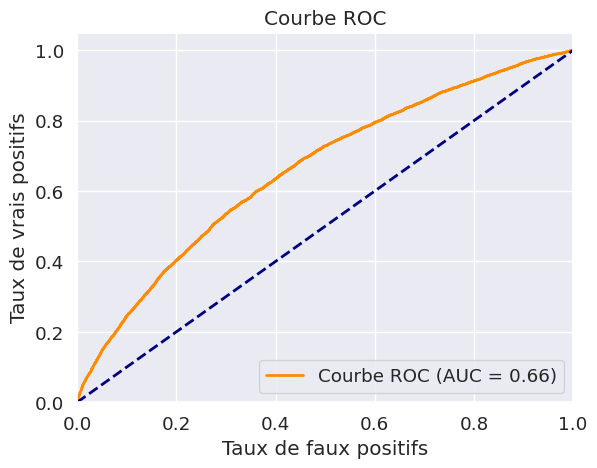

In [49]:
# Courbe ROC et AUC

y_pred_proba = voting_classifier.predict_proba(X_test_selected.to_numpy())

courbe_roc(y_test.to_numpy(), y_pred_proba[:,1])

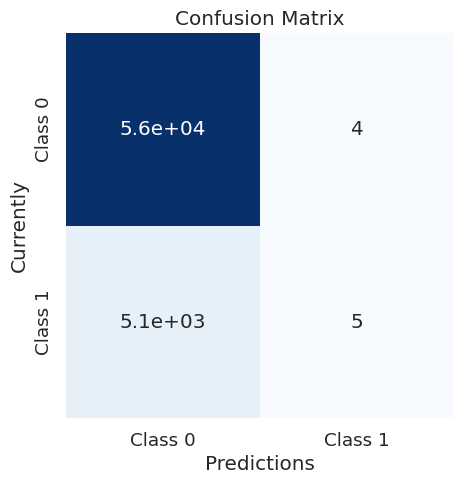

In [56]:
y_pred = voting_classifier.predict(X_test_selected.to_numpy())
plot_confusion_matrix(y_test.to_numpy(), y_pred, classes=['Class 0', 'Class 1'])

## Création d'une fonction de vote manuellement

In [50]:
# Création d'une fonction de vote

y_pred1 = log_reg.predict(X_test_selected.to_numpy())
y_pred2 = rf.predict(X_test_selected.to_numpy())
y_pred3 = xgb_model.predict(X_test_selected.to_numpy())

In [51]:
final_predictions = np.round((y_pred1 + y_pred2 + y_pred3) / 3)

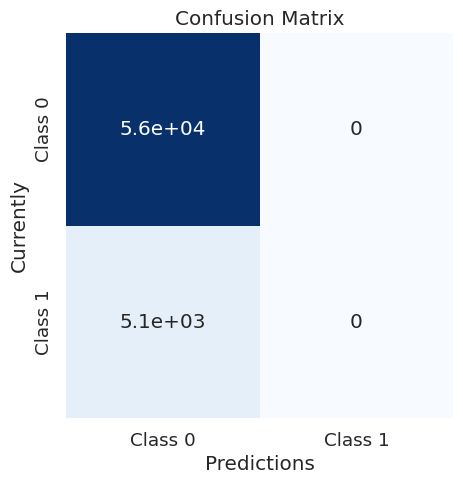

In [55]:
plot_confusion_matrix(y_test.to_numpy(),final_predictions, classes=['Class 0', 'Class 1'])